### Transforms   
데이터가 언제나 우리에게 친절한, 깔끔한 형태로 주어지지 않는다. 그래서 `Transforms`을 사용해서 
Data manipulation에 더 용이하게끔 바꿔주는 역할을 한다.  

모든 Torchvision dataset엔 2개의 파라미터가 존재함. -> transform은 feature를 수정(변경)할때 쓰고, target_transform은 정답(label)을 수정(변경)할때 사용함.  
지금 FashionMNIST의 feature는 PIL형식이고 label은 int인데, 어찌되었든 PIL 이미지 형식을 tensor로 바꿔야 하고 -> `ToTensor()`, label도 one hot encoding으로 encode해줘야함.  

In [8]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda # ToTensor() scales the image pixel values to [0.0, 1.0]
ds = datasets.FashionMNIST(
    root='data', # 루트 디렉토리에 데이터를 저장
    train=True, # 훈련 데이터를 가져옴
    download=True, # 루트 디렉토리에 데이터가 없다면 인터넷에서 다운로드
    transform=ToTensor(),# FashionMNIST의 데이터셋(feature(image), label)을 텐서로 변환
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    # target_transform은 레이블을 원-핫 인코딩된 텐서로 변환
    # Lambda는 사용자 정의 람다 함수를 정의(user defined lambda func)
    # torch.zeros(10, dtype=torch.float)는 10개의 0으로 채워진 텐서를 생성,
    # scatter_함수는 주어진 인덱스에 값을 할당하는 함수 scatter(dim, index, src)
)

아래 그림을 보자  
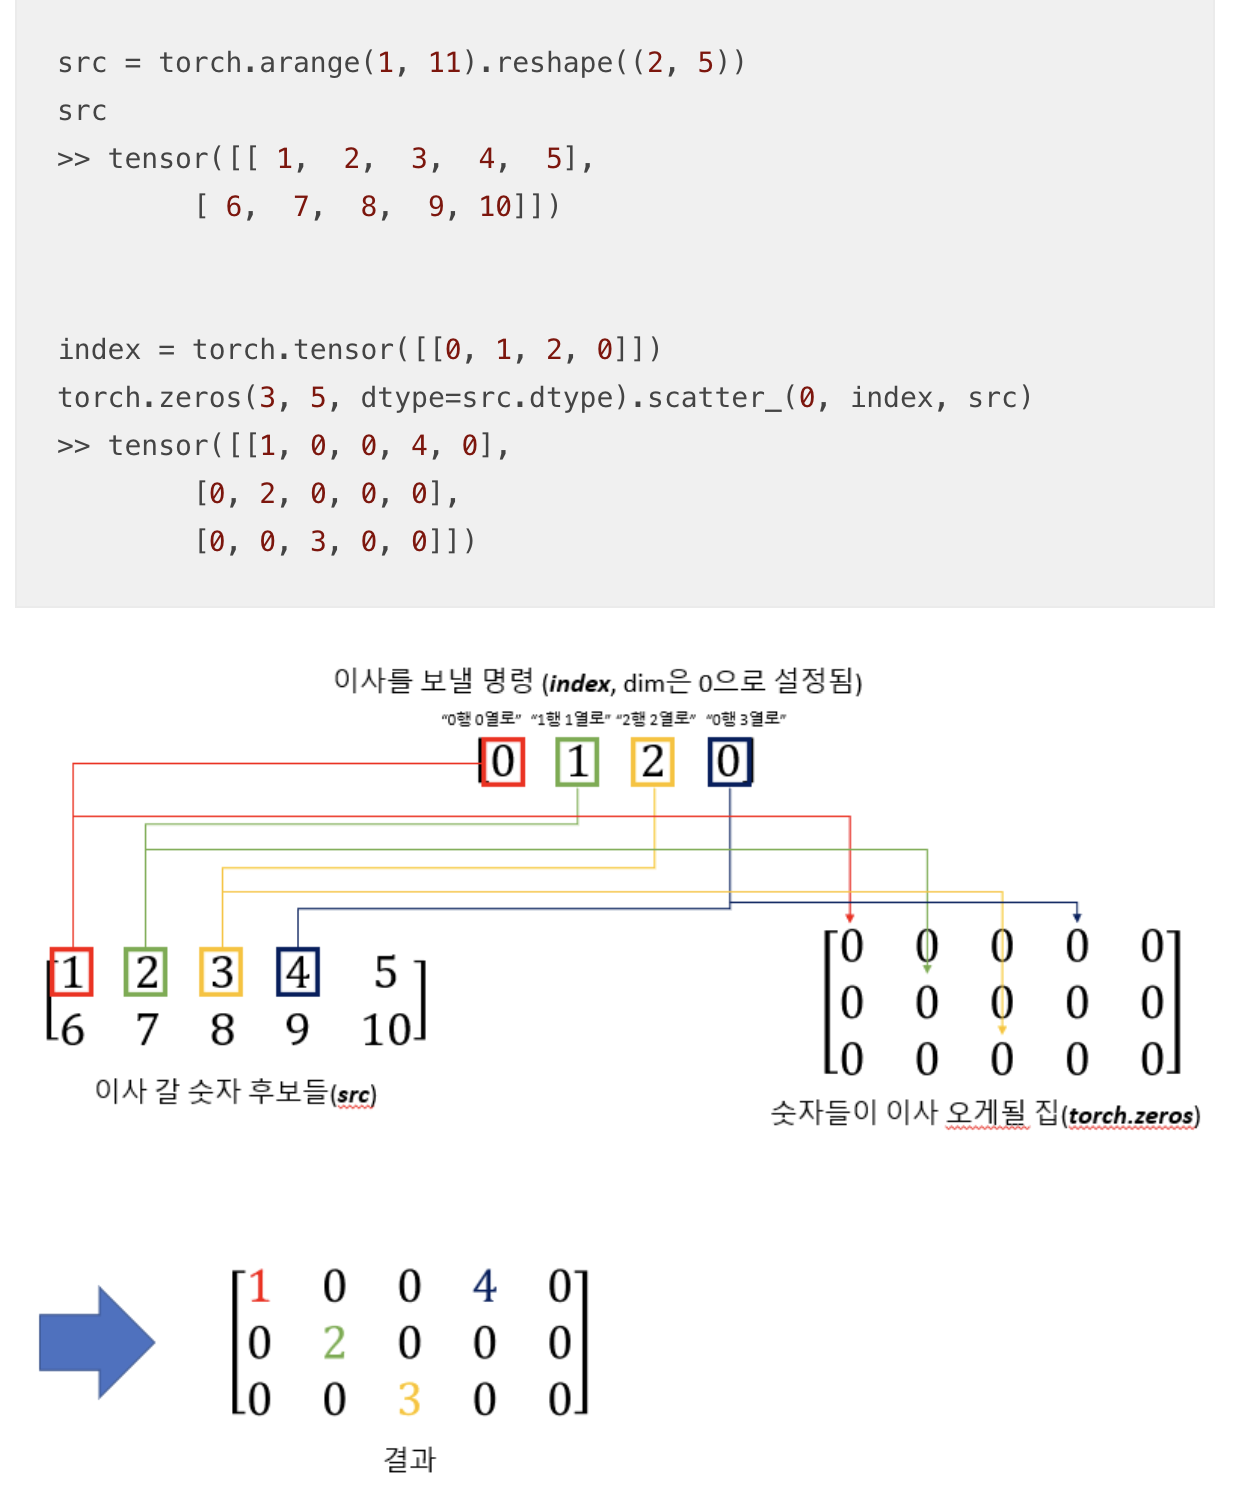


### Build The Neural Network  
NN(신경망)은 data에 대한 연산을 수행하는 layer와 module로 이뤄져 있음.  
torch.nn은 너의 NN에 필요한 building block(구성요소)을 제공해줌.  
그리고 파이토치의 모든 module은 nn.Module의 subclass임.  
NN은 다른 모듈, 다른 layer를 포함하고 있는 모듈이고. nested(중첩된)구조를 가지고 있음.  
이러한 nested structure는 more complex한 architecture 를 쉽게 구성할 수 있음.  




In [9]:
import os 
import torch
from torch import nn # 신경망 모듈
from torch.utils.data import DataLoader # 데이터셋을 반복하고 샘플링하는 기능을 제공
from torchvision import datasets,transforms # 이미지 데이터셋, 변환기능

# cuda 사용 가능 여부 확인 코드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


#### Class를 정의합시다!  
we define our NN by subclassing `nn.Module` , and initialize NN with `__init__`.  
`nn.Module`을 상속받는 모든 class는 `forward 메소드`에 input에 대한 연산을 구현함.  

In [14]:
class NN(nn.Module): # nn.Module을 상속받아 신경망 모델을 정의
    def __init__(self): # 모델의 구조와 파라미터를 정의하는 생성자
        super(NN,self).__init__() # nn.Module의 생성자를 호출
        # super -> 부모 클래스의 생성자를 호출 -> 여기서 부모클래스는 nn.Module이고 
        # nn.Module(부모클래스)의 생성자를 호출하여 nn.Module의 속성을 가지고 초기화
        self.flatten = nn.Flatten()
        # Flatten은 이미지 데이터를 1차원으로 변환
        self.linear_relu_stack = nn.Sequential( # nn.Sequential은 순서대로 모듈을 쌓아서 순차적으로 실행
            nn.Linear(28*28,512),# 28*28개의 픽셀을 입력받아 512개의 픽셀로 출력
            # nn.Linear(input, output) -> 입력과 출력의 크기를 정의
            nn.ReLU(),# activation func
            nn.Linear(512,512),
            # 왜 굳이 512개의 픽셀을 입력받아 512개의 픽셀로 출력하는가?
            # 
            nn.ReLU(),
            nn.Linear(512,10),  
        )
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Torch에서 볼 수 있는 3가지 form의 flatten함수  
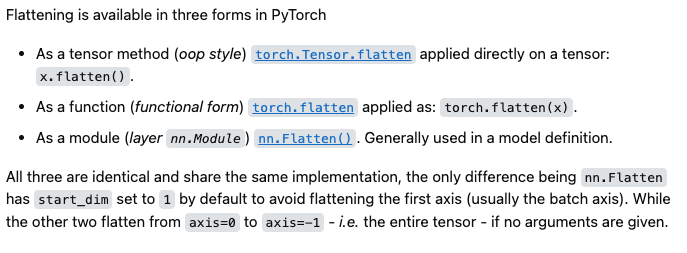
위의 경우처럼 클래스를 구현할때는 보통 `nn.Flatten()`을 많이 씀. -> default start_dim이 1이라서 첫 axis를 flatten하는 대참사를 막아줄 수 있다넹  

아래 그림은 왜 같은 input, output의 함수가 필요한가에 대한 답변
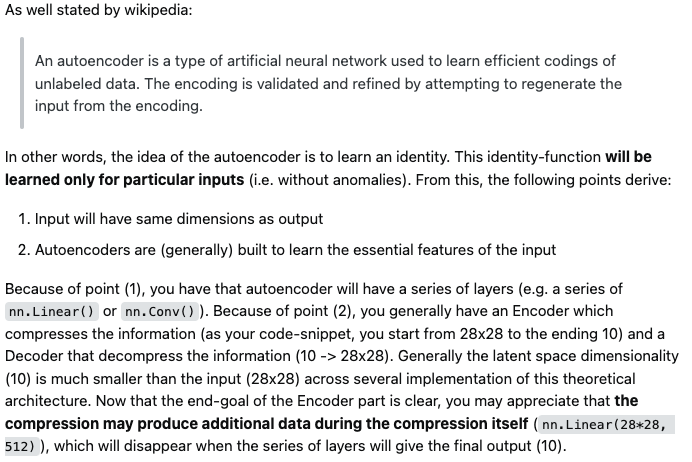  
오토인코더류의 함수에서는 항등함수(identity func)의 역할이 중요한데, 항등함수는 anomaly가 없는 상황에서 특정 입력에 대해서만 학습이 되기 때문에  
1. input will have same dimensions as output  
2. autoencoders are generally built to learn the essential features of the input   

https://stackoverflow.com/questions/75237257/what-is-the-purpose-of-having-the-same-input-and-output-in-pytorch-nn-linear-fun

In [15]:
model = NN().to(device)
print(model)

NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
